# Case with multiple risky Assets

# 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from numpy.linalg import inv
from numpy.linalg import det
from pymarkowitz import *
import bt

# 2. Generate Data

## 2.1 Load Data

In [2]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

list_symb = tickers.Symbol.to_list()
list_symb.remove('BRK.B')
list_symb.remove('BF.B')

print(tickers.head())

# Get the data for this tickers from yahoo finance
data = yf.download(list_symb,'2015-6-30','2022-6-30',interval='1d', auto_adjust=True)['Close']
print(data.head())
data_n = data

  Symbol     Security SEC filings  GICS Sector         GICS Sub-Industry  \
0    MMM           3M     reports  Industrials  Industrial Conglomerates   
1    AOS  A. O. Smith     reports  Industrials         Building Products   
2    ABT       Abbott     reports  Health Care     Health Care Equipment   
3   ABBV       AbbVie     reports  Health Care           Pharmaceuticals   
4   ABMD      Abiomed     reports  Health Care     Health Care Equipment   

     Headquarters Location Date first added      CIK      Founded  
0    Saint Paul, Minnesota       1976-08-09    66740         1902  
1     Milwaukee, Wisconsin       2017-07-26    91142         1916  
2  North Chicago, Illinois       1964-03-31     1800         1888  
3  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)  
4   Danvers, Massachusetts       2018-05-31   815094         1981  
[*********************100%***********************]  501 of 501 completed
                    A        AAL         AAP       AAPL       

## 2.2 Manipulate Data

### 2.2.1 Drop all non-values

In [3]:
data = data.dropna(0,"all")
data = data.dropna(1,"any",thresh=1764)
data = data.dropna(0)

/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_85075/2671247361.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna(0,"all")
/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_85075/2671247361.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna(1,"any",thresh=1764)
/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_85075/2671247361.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna(0)


### 2.2.2 Split in training and testing data

In [4]:
data1 = data.iloc[:252]
data2 = data.iloc[252:504]

### 2.2.3 Compute Returns

In [5]:
prices = data1.to_numpy()
prices2 = data2.to_numpy()
Returns = prices[1:,:]/prices[:-1,:]-1
Returns2 = prices2[1:,:]/prices2[:-1,:]-1

# 3. Derivatives of Cost Function

In section 7.4, we derived the discrteized cost function:

\begin{align*}
    C(\theta, \varphi)=\frac{1}{2} \sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)+\lambda \int_{\mathbb{R}^d} \pi_{t_{i}}^{\varphi}(u) \ln \pi_{t_{i}}^{\varphi}(u) d u\right)^{2} \Delta t,
\end{align*}

Further, we computed its derivatives with respect to the parameters $\theta_1$, $\theta_2$, $\varphi_1$ and $\varphi_2$:

\begin{align}
\begin{split}
\frac{\partial C}{\partial \theta_{1}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg) \Delta t
\end{split}
\end{align}

\begin{align}
\frac{\partial C}{\partial \theta_{2}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg)\left(t_{i+1}^{2}-t_{i}^{2}\right)
\end{align}

In [6]:
def Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam,d):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (list of numpy arrays with shape (d,d) and (d,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # The derivative of the cost function with respect to theta_1
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    
    # Computation of first term by using cancelation
    Term1 = (D[1,-1]-w)**2*np.exp(-theta[3]*(T-D[0,-1]))-(D[1,0]-w)**2*np.exp(-theta[3]*(T-D[0,0]))
    
    # Computation of second term by using formula for partial sum of 1 + 2 + ... + n 
    # and also 1 + 4 + 9 + ... + n^2
    Term2 = theta[2]*dt**2*(n-1)*(n-1)+(n-1)*theta[1]*dt-lam*dt*((n-1)*(d/2*(1+np.log(np.pi*lam))-np.log(det(phi[0]))+np.dot(phi[1],phi[1])*T-np.dot(phi[1],phi[1])*dt*(n-2)/2))
    
    DCT1 = Term1 + Term2
    
    return DCT1

The next function is not used but stated for completeness.

In [7]:
def Deriv_Cost_Funct_Theta(theta,phi,dt,w,T,D,lam,d):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (list of numpy arrays with shape (d,d) and (d,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # The derivative of the cost function with respect to theta_1 and theta_2
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    DCT1 = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam,d)
    
    ## Derivative of cost function with respect to theta_2
    
    # Auxiliary function
    f_D = list(map(lambda x: (x[1]-w)**2*np.exp(-Theta[3]*(T-x[0])), D.T))
    
    # Computation of remaining terms by using formula for partial sum of 1 + 2 + ... + n 
    # and also 1 + 4 + 9 + ... + n^2
    Term1 = 2*(-dt*sum(f_D[1:-1])+(D[1,-1]-w)**2*np.exp(-Theta[3]*(T-D[0,-1]))*D[0,-2]) #t0=0
    Term2 = 2*(Theta[2]*dt**3*(n-2)*(n-1)*((2*n-3)/3+1/2)+Theta[1]*dt**2*(n-2)*(n-1)/2)
    Term3 = -lam*dt**2*(n-2)*(n-1)*(d/2*(1+np.log(lam*np.pi))-np.log(det(phi[0]))+np.dot(phi[1],phi[1])*T-np.dot(phi[1],phi[1])*dt*(2*n-3)/3)
    
    DCT2 = DCT1*dt + Term1 + Term2 + Term3
    
    return np.array([DCT1,DCT2])

\begin{align}
\begin{split}
\frac{\partial C}{\partial \varphi_{1}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg) \Delta t \lambda (\varphi_1^{-1})^\top 
\end{split}
\end{align}


\begin{align}
\begin{split}
\frac{\partial C}{\partial \varphi_{2}}=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg) \Delta t\cdot\bigg(-\frac{4\varphi_2}{d\Delta t}\Big(\left(x_{i+1}-w\right)^{2} e^{-\frac{2}{d} \varphi_{2}^\top\varphi_{2}\left(T-t_{i+1}\right)}\left(T-t_{i+1}\right)-\left(x_{i}-w\right)^{2} e^{-\frac{2}{d} \varphi_{2}^\top\varphi_{2}\left(T-t_{i}\right)}\left(T-t_{i}\right)\Big)-2\varphi_2\lambda\left(T-t_{i}\right)\bigg).
\end{split}
\end{align}

In [8]:
def Deriv_Cost_Funct_Phi(theta,phi,dt,w,T,D,lam,d):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (list of numpy arrays with shape (d,d) and (d,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # The derivative of the cost function with respect to phi
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    DCT1 = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam,d)
    
    ## Derivative of cost function with respect to phi_0
    DCP0 = lam*inv(phi[0]).T*DCT1
    
    ## Derivative of cost function with respect to phi_1
    
    # Auxiliary function
    #f_D = list(map(lambda x: (x[1]-w)**2*np.exp(-theta[3]*(T-x[0])), D.T))
    
    # Value function
    f_x = lambda x: (x-w)**2
    f1_t = lambda t: np.exp(-theta[3]*(T-t))
    f2_t = lambda t: theta[2]*t**2+theta[1]*t+theta[0]
    
    V = f_x(D[1,:])*f1_t(D[0,:])+f2_t(D[0,:])
    
    # Derivative of value function
    Deriv_V = (V[1:]-V[:-1])/dt
    
    # Differential entropy term
    H = list(map(lambda x: -lam*(d/2*(1+np.log(lam*np.pi))-np.log(det(phi[0]))+np.dot(phi[1],phi[1])*(T-x)), D[0,:-1]))
    
    # First factor
    C1 = (Deriv_V+H)*dt
    
    f2 = list(map(lambda x: 4*phi[1]/d*(x[1]-w)**2*np.exp(-2*np.dot(phi[1],phi[1])/d*(T-x[0]))*(T-x[0])+lam*phi[1]*x[0]**2, D.T))
    f3 = list(map(lambda x: -2*phi[1]*lam*(T-x),D[0,:-1]))
    
    # Second factor
    C2 = -(np.asarray(f2[1:])-np.asarray(f2[:-1]))/dt+f3
    C2 = np.reshape(np.asarray(C2),(n-1,d))
    
    DCP1 = sum(np.multiply(C2, C1[:, np.newaxis]))
    
    return [DCP0,DCP1]

# 4. The multidimensional EMV Algorithm

In [9]:
def EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Return,theta,phi,dt,T,lam,d):
    
    ## Input: 
    # M: Number of iterations (int>0)
    # N: Sample average size (int>0)
    # eta_phi, eta_theta, alpha: learning rates (float)
    # x0: Initial wealth (float)
    # z: Target payoff (float)
    # w: Lagrange multiplier (float)
    # Return: Returns of risky asset (numpy array with shape (T/dt,1))
    # theta: Initail parameter (numpy array with shape (4,1))
    # phi: Initial parameter (numpy array with shape (2,1))
    # dt: time intervall (float>0)
    # T: terminal time (float or int >0)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # mean: The learned mean function of the control process
    # var: The learned variance function of the control process
    # terminal_wealth: The achieved terminal wealth in each iteration
    # var_array: The achieved variance in each iteration
    # SR: The learned Sharpe ratio
    
    ## Set seed
    np.random.seed(10)
    
    ## Initialization
    D1 = Return.shape[1]
    
    N1 = int(np.floor(M/N))
    
    # Initialize arrays to store the terminal wealth and the variance of each iteration  
    terminal_wealth = np.zeros([M])
    terminal_wealth2 = np.zeros([M])
    var_array = np.zeros([M])
    
    # Number of time steps
    T1 = int(np.floor(T/dt))
    
    # Initial mean and variance function
    mean = lambda x: -np.dot(inv(phi[0]),phi[1]*np.sqrt(2/d))*(x-w)
    var =  lambda x: (lam/2)*np.exp(np.float128(2/d*np.dot(phi[1],phi[1])*(T-x)))*inv(np.dot(phi[0].T,phi[0]))
        
    ## Iterations
    for k in range(1, M+1):
        
        # Initialization
        x = float(x0)
        D = np.zeros([2,T1])
        D[1,0] = np.array(x)
        D[0,:] = np.linspace(0,T,T1) 
        
        # Choosing Assets (randomly)
        selected = np.random.choice(D1, d, replace=False)
        R = Return[:,selected]
        
        # Remeber parameter from last episode
        phi0_int = phi[0]
        phi1_int = phi[1]
        theta_int = theta
        w_int = w
        
        # Episodes
        for i in range(1, T1):
            
            # Mean and Variance
            variance = var((i-1)*dt)
            mean_1 = mean(x)
            u = np.random.multivariate_normal(mean_1.reshape((np.product(mean_1.shape),)),variance)
            
            # Compute the wealth at the next time point
            x = x+float(np.dot(u,R[i-1,:]))
            x = np.clip(x,x0-1*z,x0+1*z)
            
            # Update the set of samples
            D[1,i:] = np.array(x)
            
            # Compute the Derivative of the cost function with respect to theta
            Cost_Derivative_theta = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D[:,:(i+1)],lam,d)
            
            # Update theta
            theta[1] = theta[1] - eta_theta*Cost_Derivative_theta
            theta[2] = -lam/2*np.dot(phi[1],phi[1])
            theta[0] = -theta[2]*T**2-theta[1]*T-(w-z)**2
            theta[3] = 2*np.dot(phi[1],phi[1])/d
            
            # Compute the Derivative of the cost function with respect to phi
            Cost_Derivative_phi = Deriv_Cost_Funct_Phi(theta,phi,dt,w,T,D[:,:(i+1)],lam,d)
            
            # Update phi
            phi[0] = phi[0] - eta_phi*Cost_Derivative_phi[0]
            phi[1] = phi[1] - eta_phi*Cost_Derivative_phi[1]
            
        # Store terminal wealth and variance of k-th iteration
        terminal_wealth[k-1] = x
        var_array[k-1] = np.var(D[1,:])
        
        # Update Lagrange multiplier
        if k % N == 0:
            w = w - alpha*(1/N*(np.sum(terminal_wealth[(k-N):k]))-z)
        
        # Mean of last 300 parameters
        if M-k < 300:
            if M-k == 299:
                w_mean = w_int
                phi0_mean = phi0_int
                phi1_mean = phi1_int
            w_mean = np.mean([w_mean,w])
            phi0_mean = np.mean([phi0_mean,phi[0]],axis = 0)
            phi1_mean = np.mean([phi1_mean,phi[1]],axis = 0)
        
        # Update control process
        mean = lambda x: -np.dot(inv(phi[0]),phi[1]*np.sqrt(2/d))*(x-w)
        var =  lambda x: (lam/2)*np.exp(np.float128(2/d*np.dot(phi[1],phi[1])*(T-x)))*inv(np.dot(phi[0].T,phi[0]))
        
        # Print current state
        if k % 100 == 0:
            print(w)
            print(str(round(k/M*100,2)) + " %" + "  |  Average Terminal Wealth: " + str(round(np.mean(terminal_wealth[k-100:k]),2)) + "  |  Average Variance: " + str(round(np.var(terminal_wealth[k-100:k]),4)))
        
    return [[mean,var,terminal_wealth,w_mean,phi0_mean,phi1_mean]]

# 5. Empirical Analysis

## 5.1 Training

### 5.1.1 Initialization

In [10]:
# Number of episodes
M = 10000
# Number for Lagrange multiplier update
N = 10
# Exloration weight
lam = 0.01
# Time horizon
T = 1
# Time interval
dt = T/120
# Investment target
z = 1.4
# Learning rates
alpha = 0.05
eta_phi = 0.0005
eta_theta = 0.0005
# Initial wealth
x0 = 1.
# Initial Lagrange multiplier
w = 1.
# Number of risky assets
d = 20
# Initial parameters
np.random.seed(10)
phi0 =  (np.eye(d))+np.random.rand(d,d)/100
phi1 = np.random.sample(d)/100
phi = [phi0,phi1]
theta = np.random.sample(4)

### 5.1.2 Training

In [11]:
Result = EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Returns,theta,phi,dt,T,lam,d)

1.1952324002069674
1.0 %  |  Average Terminal Wealth: 1.01  |  Average Variance: 0.0063
1.3964456282483126
2.0 %  |  Average Terminal Wealth: 1.0  |  Average Variance: 0.0052
1.5962579427947197
3.0 %  |  Average Terminal Wealth: 1.0  |  Average Variance: 0.004
1.8010335866011176
4.0 %  |  Average Terminal Wealth: 0.99  |  Average Variance: 0.0037
2.002058602349343
5.0 %  |  Average Terminal Wealth: 1.0  |  Average Variance: 0.0032
2.2006414855718743
6.0 %  |  Average Terminal Wealth: 1.0  |  Average Variance: 0.0043
2.1605833868927236
7.0 %  |  Average Terminal Wealth: 1.48  |  Average Variance: 0.1715
1.9725342477174783
8.0 %  |  Average Terminal Wealth: 1.78  |  Average Variance: 0.0741
1.8434787870035165
9.0 %  |  Average Terminal Wealth: 1.66  |  Average Variance: 0.0688
1.7094839430179678
10.0 %  |  Average Terminal Wealth: 1.67  |  Average Variance: 0.0514
1.635510376801166
11.0 %  |  Average Terminal Wealth: 1.55  |  Average Variance: 0.0617
1.6070768956519172
12.0 %  |  Average

1.5646377497172725
94.0 %  |  Average Terminal Wealth: 1.46  |  Average Variance: 0.1016
1.5698394990635203
95.0 %  |  Average Terminal Wealth: 1.39  |  Average Variance: 0.0964
1.5915875032423812
96.0 %  |  Average Terminal Wealth: 1.36  |  Average Variance: 0.1159
1.57142231072508
97.0 %  |  Average Terminal Wealth: 1.44  |  Average Variance: 0.0939
1.545306166555728
98.0 %  |  Average Terminal Wealth: 1.45  |  Average Variance: 0.0969
1.5385553193918309
99.0 %  |  Average Terminal Wealth: 1.41  |  Average Variance: 0.1026
1.5548384661099988
100.0 %  |  Average Terminal Wealth: 1.37  |  Average Variance: 0.0801


### 5.1.3 Plots

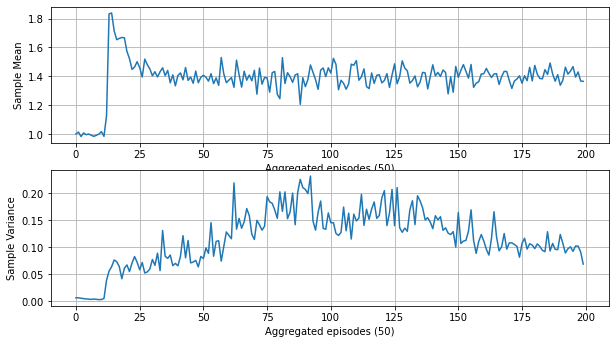

Annualized return: 40.54%
Standard deviation: 32.4%
Sharpe Ratio: 1.25


In [12]:
%matplotlib inline
# Mean of terminal wealth over 50 iterations
terminal_wealth = Result[0][2]
terminal_wealth_50 = np.mean(terminal_wealth.reshape(-1, 50), axis=1)

# Standard deviation of terminal wealthes over 50 iterations
Std_50 = np.var(terminal_wealth.reshape(-1, 50), axis=1)

##Plots
plt.rcParams["figure.figsize"] = (10,5.5)
# sample means
plt.subplot(2, 1, 1)
plt.plot(terminal_wealth_50)
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Mean")
# sample variances
plt.subplot(2, 1, 2)
plt.plot(Std_50)
#plt.yscale('log')
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Variance")
plt.show()

# Print
ann_return = np.mean(terminal_wealth[-2000:])/x0-1
std_return = np.std(terminal_wealth[-2000:])
print('Annualized return: ' + str(round(ann_return*100,2)) + '%')
print('Standard deviation: ' + str(round(std_return*100,2)) + '%')
print('Sharpe Ratio: ' + str(round((ann_return)/std_return,2)))

# 6. Backtesting

### 6.2.1 Initialize

In [13]:
# Time horizon
T = 1
# Time interval
dt = T/252
# Trading cost
p = 0.5
# Number of time intervals
T1 = int(np.floor(T/dt))
# Initial wealth
x0 = 1
# number of assets
d = 20
# Lagrange Multiplier
w = 8.
# Number of repetitions
N = 100
# Returns of testing window
Returns2 = prices2[1:,:]/prices2[:-1,:]-1
D1 = Returns2.shape[1]

# Initialize vectors
wealth_EMV = np.zeros([N,T1])
wealth_EMV_Lev = np.zeros([N,T1])
wealth_EMV_Lev1 = np.zeros([N,T1])
wealth_EMV_Lev2 = np.zeros([N,T1])
wealth_equal = np.zeros([N,T1])
wealth_strat = np.zeros([N,T1])
wealth_EMV[:,0] = x0
wealth_EMV_Lev[:,0] = x0
wealth_EMV_Lev1[:,0] = x0
wealth_EMV_Lev2[:,0] = x0
wealth_equal[:,0] = x0

# Trained Mean Function with last 300 parameter average
mean = lambda x: -np.dot(inv(Result[0][4]),Result[0][5]*np.sqrt(2/d))*(x-Result[0][3])

#mean = Result[0][0]

### 6.2.2 Compute Performance

In [14]:
for j in range(0,N):
    
    # Initialize wealth process
    x_EMV = x0
    x_EMV_Lev = x0
    x_EMV_Lev1 = x0
    x_EMV_Lev2 = x0
    x_equal = x0
    
    # Select randomly d assets
    np.random.seed(j*10)
    selected = np.random.choice(D1, d, replace=False)
    R = Returns2[:,selected]
    
    # Initialization
    u_EMV = np.repeat(0,d)
    u_EMV_Lev = np.repeat(0,d)
    u_EMV_Lev1 = np.repeat(0,d)
    u_EMV_Lev2 = np.repeat(0,d)
    
    for i in range(1, T1):
            
            # Remeber last allocation
            u_EMV_l = u_EMV
            u_EMV_Lev_l = u_EMV_Lev
            u_EMV_Lev1_l = u_EMV_Lev1
            u_EMV_Lev2_l = u_EMV_Lev2
        
            # Evaluate Allocation
            u_EMV = mean(float(x_EMV))
            u_EMV_Lev = mean(float(x_EMV_Lev))
            u_EMV_Lev1 = mean(float(x_EMV_Lev1))
            u_EMV_Lev2 = mean(float(x_EMV_Lev2))
            u_equal = np.repeat(1/d,d)
            
            # Leverage constraints
            u_EMV_Lev = u_EMV_Lev/np.linalg.norm(u_EMV_Lev,ord = 1)*x_EMV_Lev*2
            u_EMV_Lev1 = u_EMV_Lev1/np.linalg.norm(u_EMV_Lev1,ord = 1)*x_EMV_Lev1*1.5
            u_EMV_Lev2 = u_EMV_Lev2/np.linalg.norm(u_EMV_Lev2,ord = 1)*x_EMV_Lev2
            
            # Compute allocation before rebalancing
            if i > 1:
                u_EMV_l = u_EMV_l*(1+R[i-2,:])
                u_EMV_Lev_l = u_EMV_Lev_l*(1+R[i-2,:])
                u_EMV_Lev1_l = u_EMV_Lev1_l*(1+R[i-2,:])
                u_EMV_Lev2_l = u_EMV_Lev2_l*(1+R[i-2,:])
                
            # Compute wealth
            x_EMV = x_EMV+float(np.dot(u_EMV,R[i-1,:]))-p/100*np.linalg.norm(u_EMV-u_EMV_l,ord = 1)
            x_EMV_Lev = x_EMV_Lev+float(np.dot(u_EMV_Lev,R[i-1,:]))-p/100*np.linalg.norm(u_EMV_Lev-u_EMV_Lev_l,ord = 1)
            x_EMV_Lev1 = x_EMV_Lev1+float(np.dot(u_EMV_Lev1,R[i-1,:]))-p/100*np.linalg.norm(u_EMV_Lev1-u_EMV_Lev1_l,ord = 1)
            x_EMV_Lev2 = x_EMV_Lev2+float(np.dot(u_EMV_Lev2,R[i-1,:]))-p/100*np.linalg.norm(u_EMV_Lev2-u_EMV_Lev2_l,ord = 1)
            x_equal = x_equal+float(np.dot(u_equal,R[i-1,:]))
            
            # Store values
            wealth_EMV[j,i] = x_EMV
            wealth_EMV_Lev[j,i] = x_EMV_Lev
            wealth_EMV_Lev1[j,i] = x_EMV_Lev1
            wealth_EMV_Lev2[j,i] = x_EMV_Lev2
            wealth_equal[j,i] = x_equal
            

In [15]:
# EMV
AR_EMV = np.mean(wealth_EMV[:,-1])-1
SD_EMV = np.std(wealth_EMV[:,-1])
SR_EMV = AR_EMV/SD_EMV
# EMV (L = 200%)
AR_EMV_L = np.mean(wealth_EMV_Lev[:,-1])-1
SD_EMV_L = np.std(wealth_EMV_Lev[:,-1])
SR_EMV_L = AR_EMV_L/SD_EMV_L
# EMV (L = 150%)
AR_EMV_L1 = np.mean(wealth_EMV_Lev1[:,-1])-1
SD_EMV_L1 = np.std(wealth_EMV_Lev1[:,-1])
SR_EMV_L1 = AR_EMV_L1/SD_EMV_L1
# EMV (L = 100%)
AR_EMV_L2 = np.mean(wealth_EMV_Lev2[:,-1])-1
SD_EMV_L2 = np.std(wealth_EMV_Lev2[:,-1])
SR_EMV_L2 = AR_EMV_L2/SD_EMV_L2
# Equally weighted
AR_equal = np.mean(wealth_equal[:,-1])-1
SD_equal = np.std(wealth_equal[:,-1])
SR_equal = AR_equal/SD_equal


data_tabl = {'EMV':[str(round(AR_EMV*100,2))+'%', str(round(SD_EMV*100,2))+'%', str(round(SR_EMV,2))],
             'EMV (L = 200%)':[str(round(AR_EMV_L*100,2))+'%', str(round(SD_EMV_L*100,2))+'%', str(round(SR_EMV_L,2))],
            'EMV (L = 150%)':[str(round(AR_EMV_L1*100,2))+'%', str(round(SD_EMV_L1*100,2))+'%', str(round(SR_EMV_L1,2))],
            'EMV (L = 100%)':[str(round(AR_EMV_L2*100,2))+'%', str(round(SD_EMV_L2*100,2))+'%', str(round(SR_EMV_L2,2))],
            'Equal':[str(round(AR_equal*100,2))+'%', str(round(SD_equal*100,2))+'%', str(round(SR_equal,2))]}
 
# Create DataFrame
df = pd.DataFrame(data_tabl)
df.index = ['Return', 'Standard Deviation', 'Sharpe Ratio']
# Print the output.
df

,EMV,EMV (L = 200%),EMV (L = 150%),EMV (L = 100%),Equal
Return,55.92%,45.82%,39.37%,25.52%,24.51%
Standard Deviation,0.37%,6.86%,8.8%,5.8%,4.47%
Sharpe Ratio,150.46,6.68,4.48,4.4,5.49


## 6.3 Plots

<IPython.core.display.Javascript object>


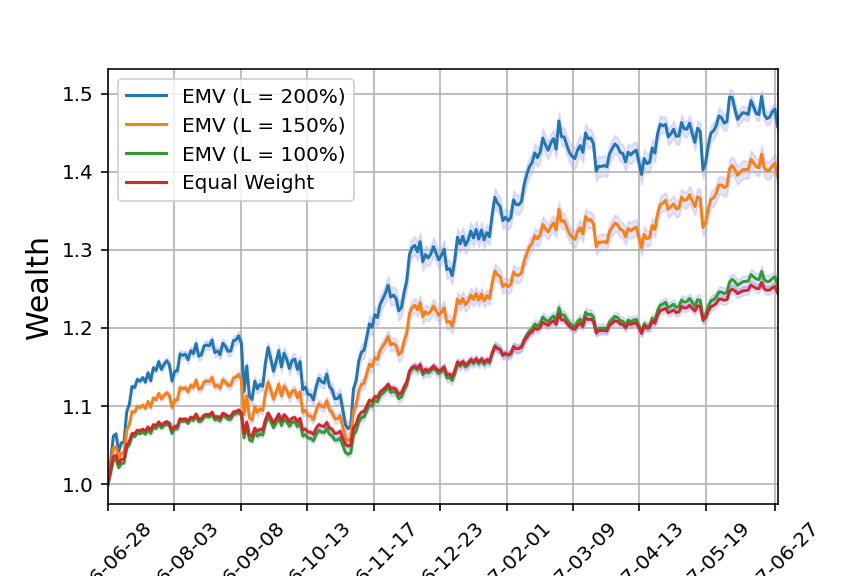

Text(0, 0.5, 'Wealth')

In [16]:
%matplotlib notebook

# x-axis
date = pd.Series(data2.index.format('%Y-%m-%d')).to_numpy()[1:]
date = [x.split()[0] for x in date]
dt = np.array(date)
dt = dt.tolist()

fig, ax = plt.subplots()
ax.set_xlim((0,252))

## EMV
# Mean
EMV_mean = np.mean(wealth_EMV,axis=0)
# 95%-Confidence interval
ci_EMV = 1.96 * np.std(wealth_EMV,axis = 0)/np.sqrt(len(wealth_EMV[1,:]))
# Plot
#ax.plot(np.linspace(0,252,num=252),EMV_mean, label='EMV')
#ax.fill_between(np.linspace(0,252,num=252),(EMV_mean-ci_EMV), (EMV_mean+ci_EMV), color='b', alpha=.1, linewidth=0)
ax.set_xticks([0,25,50,75,100,125,150,175,200,225,251], np.take(dt,np.array([0,25,50,75,100,125,150,175,200,225,251])),rotation = 45)
ax.grid()

## EMV with Leverage 200%
# Mean
Lev_mean = np.mean(wealth_EMV_Lev,axis=0)
# 95%-Confidence interval
ci_Lev = 1.96 * np.std(wealth_EMV_Lev,axis = 0)/np.sqrt(len(wealth_EMV_Lev[1,:]))
# Plot
ax.plot(np.linspace(0,252,num=252),Lev_mean, label='EMV (L = 200%)')
ax.fill_between(np.linspace(0,252,num=252),(Lev_mean-ci_Lev), (Lev_mean+ci_Lev), color='b', alpha=.1)

## EMV with Leverage 150%
# Mean
Lev_mean1 = np.mean(wealth_EMV_Lev1,axis=0)
# 95%-Confidence interval
ci_Lev1 = 1.96 * np.std(wealth_EMV_Lev1,axis = 0)/np.sqrt(len(wealth_EMV_Lev1[1,:]))
# Plot
ax.plot(np.linspace(0,252,num=252),Lev_mean1, label='EMV (L = 150%)')
ax.fill_between(np.linspace(0,252,num=252),(Lev_mean1-ci_Lev1), (Lev_mean1+ci_Lev1), color='b', alpha=.1)

## EMV with Leverage 100%
# Mean
Lev_mean2 = np.mean(wealth_EMV_Lev2,axis=0)
# 95%-Confidence interval
ci_Lev2 = 1.96 * np.std(wealth_EMV_Lev2,axis = 0)/np.sqrt(len(wealth_EMV_Lev2[1,:]))
# Plot
ax.plot(np.linspace(0,252,num=252),Lev_mean2, label='EMV (L = 100%)')
ax.fill_between(np.linspace(0,252,num=252),(Lev_mean2-ci_Lev2), (Lev_mean2+ci_Lev2), color='b', alpha=.1)

## Equally weighted Portfolio
# Mean
equal_mean = np.mean(wealth_equal,axis=0)
# 95%-Confidence interval
ci_equal = 1.96 * np.std(wealth_equal,axis = 0)/np.sqrt(len(wealth_equal[1,:]))
# Plot
ax.plot(np.linspace(0,252,num=252),equal_mean, label='Equal Weight')
ax.fill_between(np.linspace(0,252,num=252),(equal_mean-ci_equal), (equal_mean+ci_equal), color='b', alpha=.1)

ax.legend(loc = 'upper left')
plt.rcParams["figure.figsize"] = (10,8)
plt.ylabel('Wealth', fontsize=15)